# 가상의 주가 가정

In [96]:
import numpy as np
import pandas as pd
import statsmodels

import matplotlib.pyplot as plt

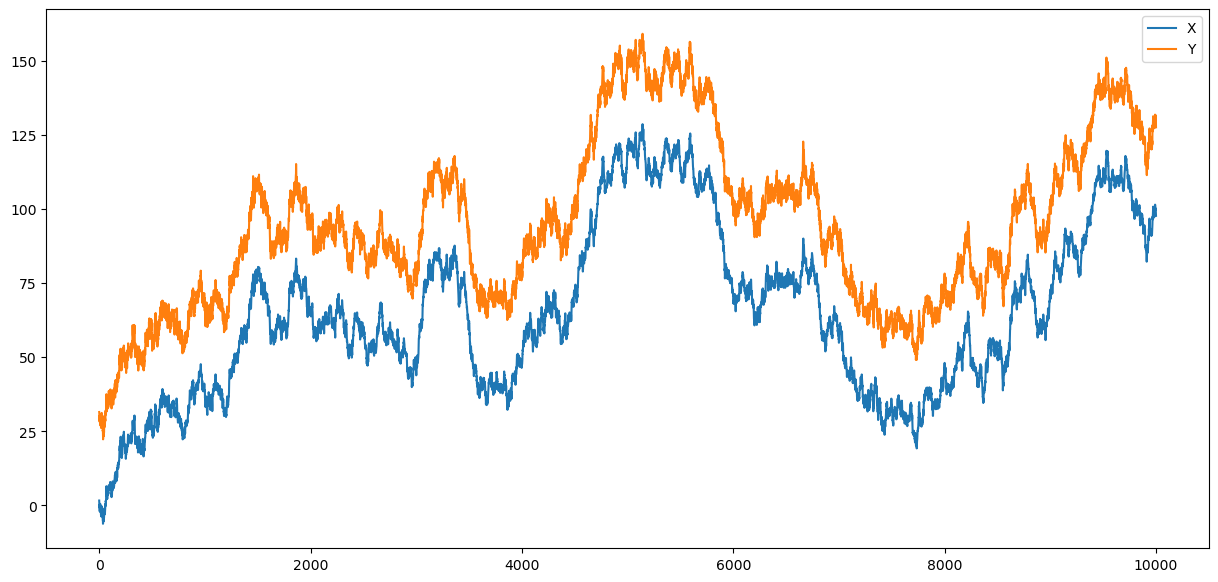

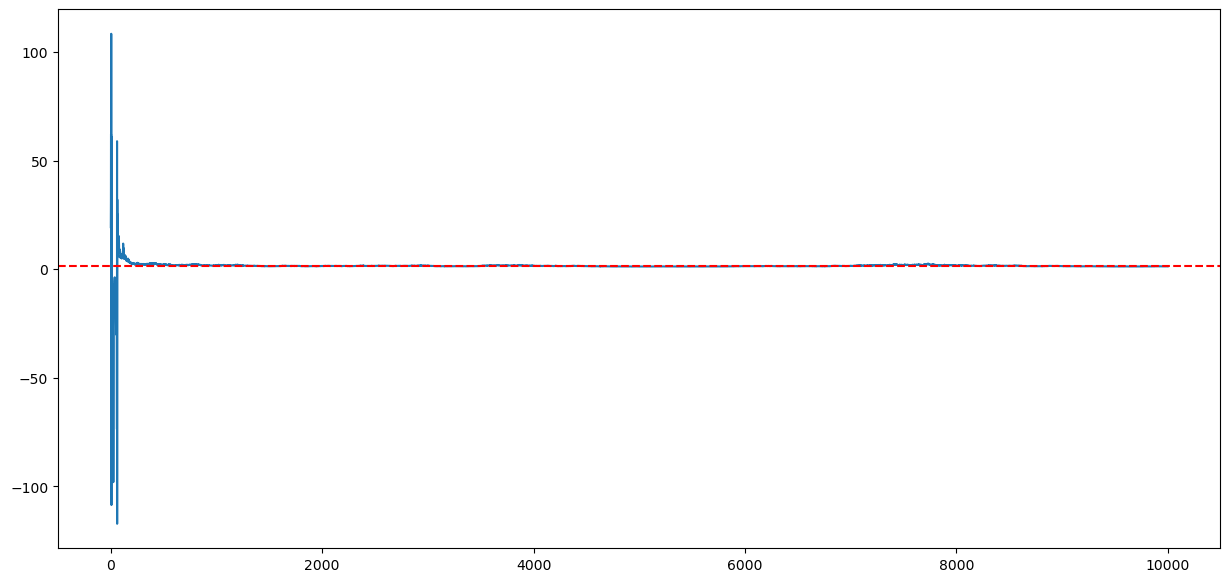

In [2]:
np.random.seed(1)

X_return = np.random.normal(0, 1, 10000)
X = pd.Series(np.cumsum(X_return), name='X')

noise = np.random.normal(0, 1, 10000)
Y = X + 30 + noise
Y.name = 'Y'

path = pd.concat([X, Y], axis=1)
path.plot(figsize=(15,7))
plt.show()

(path['Y']/path['X']).plot(figsize=(15, 7))
plt.axhline((path['Y']/path['X']).mean(), color='red', linestyle='--') 
plt.show()

In [97]:
#1년은 240일, 1달은 20일로 설정
#상관관계 높은 m 쌍의 가상주식 수익률 시계열 만들기

m=3
n=2*m
T=1200
init_price = np.random.randint(low = 3000, high = 10000, size = n)
corr = np.array([0.95, 0.9, 0.85]) # 상관관계
mu = np.array([0.1, 0.15, 0.2])/240 #연간수익률->일간수익률
sigma = np.array([0.2, 0.3, 0.4]) # 연간변동성
sigma = np.sqrt((sigma**2)/240) # 일간으로 변환

# corr = np.random.rand(m)*0.2+0.8 # 상관관계 0.8~1 랜덤생성
# mu = (np.random.rand(m)*0.1+0.1)/240 # 연평균수익률 10~20%(일간으로 변환) 랜덤생성
# sigma = np.sqrt((np.random.rand(m)*0.2+0.2)**2/240) # 연평균변동성 20~40%(일간으로 변환) 랜덤생성

#가상 수익률 생성
rets = np.random.normal(size = (T, n)) # 정규분포난수 생성
rets[:, 1::2] = corr*rets[:, 0::2] + np.sqrt(1-corr**2)*rets[:, 1::2]  # 상관관계 부여
rets[:, 0::2] = rets[:, 0::2]*sigma + mu #평균, 변동성 부여
rets[:, 1::2] = rets[:, 1::2]*sigma + mu #평균, 변동성 부여
rets[0,:] = 0 #시작시점 리턴 0

stock_names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
returns = pd.DataFrame(rets, columns = stock_names)
disc_rets = np.exp(returns)
prices = disc_rets.cumprod(axis=0)*init_price

returns = returns.stack().to_frame()
returns.columns = ['return']
prices = prices.stack().to_frame()
prices.columns = ['price']

stocks_df = pd.merge(returns, prices, left_index=True, right_index = True)
stocks_df = stocks_df.unstack()

In [4]:
from sklearn.model_selection import train_test_split

price_df = stocks_df['price']
ret_df = stocks_df['return']

price_df_coint, price_df_trade, ret_df_coint, ret_df_trade = train_test_split(price_df, ret_df, train_size=0.7, shuffle=False)
price_df_coint.shape, price_df_trade.shape, ret_df_coint.shape, ret_df_trade.shape

((840, 6), (360, 6), (840, 6), (360, 6))

In [98]:
from itertools import combinations as cb
from statsmodels.tsa.stattools import coint

pair_list = []

for pairs in list(cb(ret_df.columns, 2)):
    pair1 = pairs[0]
    pair2 = pairs[1]
    score, pvalue, _ = coint(ret_df_coint[pair1], ret_df_coint[pair2])
    
    if pvalue <= 0.05:
        pair_list.append(pairs)

pair_list[0:5]

[('A1', 'A2'), ('A1', 'B1'), ('A1', 'B2'), ('A1', 'C1'), ('A1', 'C2')]

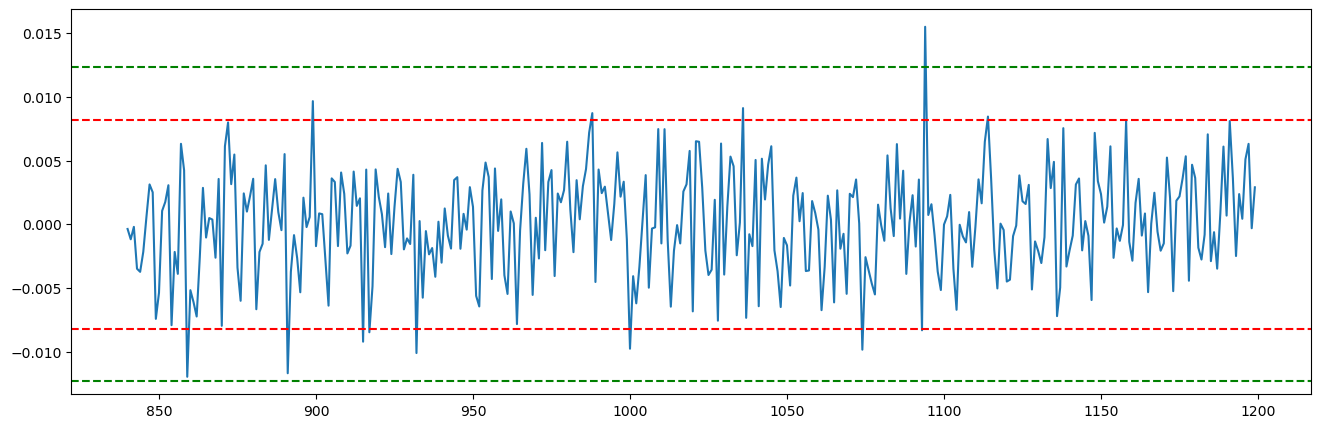

In [6]:
(ret_df_trade.A1 - ret_df_trade.A2).plot(figsize=(16, 5))
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() *  2, linestyle='--', c='red')
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() * -2, linestyle='--', c='red')
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() *  3, linestyle='--', c='green')
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() * -3, linestyle='--', c='green')
plt.show()

In [95]:
ret_df_

[('A1', 'A2'),
 ('A1', 'B1'),
 ('A1', 'B2'),
 ('A1', 'C1'),
 ('A1', 'C2'),
 ('A2', 'B1'),
 ('A2', 'B2'),
 ('A2', 'C1'),
 ('A2', 'C2'),
 ('B1', 'B2'),
 ('B1', 'C1'),
 ('B1', 'C2'),
 ('B2', 'C1'),
 ('B2', 'C2'),
 ('C1', 'C2')]

In [8]:
'''with std standard signal'''
signal_tmp = pd.DataFrame(ret_df_trade.A1 - ret_df_trade.A2, columns=['Spread'])
signal = (ret_df_trade.A1 - ret_df_trade.A2).std() * 1.5

signal_tmp['signal'] = np.where(signal_tmp > signal, 1, np.where(signal_tmp < -signal, -1, 0))


In [22]:
from statsmodels import stats

stats.no

In [30]:
def parameter(family, tau):
	''' Estimate the parameters for three kinds of Archimedean copulas
	according to association between Archimedean copulas and the Kendall rank correlation measure
	'''
	
	if  family == 'clayton':
		return 2 * tau / (1 - tau)
	
	elif family == 'frank':
		
		'''
		debye = quad(integrand, sys.float_info.epsilon, theta)[0]/theta  is first order Debye function
		frank_fun is the squared difference
		Minimize the frank_fun would give the parameter theta for the frank copula 
		''' 
		
		integrand = lambda t: t / (np.exp(t) - 1)  # generate the integrand
		frank_fun = lambda theta: ((tau - 1) / 4.0  - (quad(integrand, sys.float_info.epsilon, theta)[0] / theta - 1) / theta) ** 2
		
		return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x 
	
	elif family == 'gumbel':
		return 1 / (1 - tau)

def lpdf_copula(family, theta, u, v):
	'''Estimate the log probability density function of three kinds of Archimedean copulas
	'''
	
	if  family == 'clayton':
		pdf = (theta + 1) * ((u ** (-theta) + v ** (-theta) - 1) ** (-2 - 1 / theta)) * (u ** (-theta - 1) * v ** (-theta - 1))
		
	elif family == 'frank':
		num = -theta * (np.exp(-theta) - 1) * (np.exp(-theta * (u + v)))
		denom = ((np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)) ** 2
		pdf = num / denom
		
	elif family == 'gumbel':
		A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
		c = np.exp(-A ** (1 / theta))
		pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
		
	return np.log(pdf)

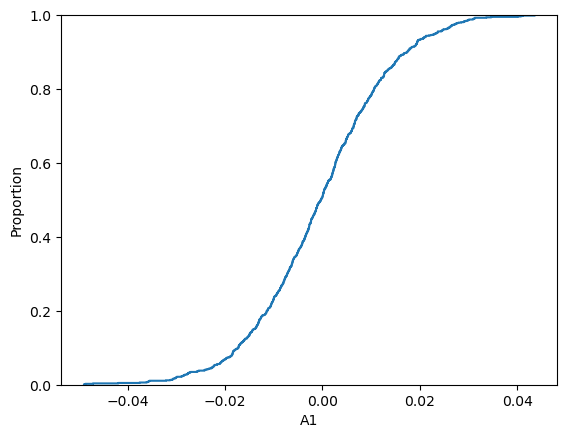

In [37]:
import seaborn as sns

sns.ecdfplot(b.A1)
plt.show()

In [90]:
def ecdf (df):
    uniq_df = df.unique()
    x_values = np.linspace(min(uniq_df), max(uniq_df), num=len(uniq_df))
    size_df = uniq_df.size
    
    y_values = []
    for i in x_values: 
        tmp = df[df<= i]
        value = tmp.size/size_df
        y_values.append(value)
    return np.array(y_values)

(array([  4.,  10.,  33., 112., 204., 229., 153.,  62.,  27.,   5.]),
 array([-0.04894283, -0.03968592, -0.03042902, -0.02117211, -0.01191521,
        -0.0026583 ,  0.00659861,  0.01585551,  0.02511242,  0.03436932,
         0.04362623]),
 <BarContainer object of 10 artists>)

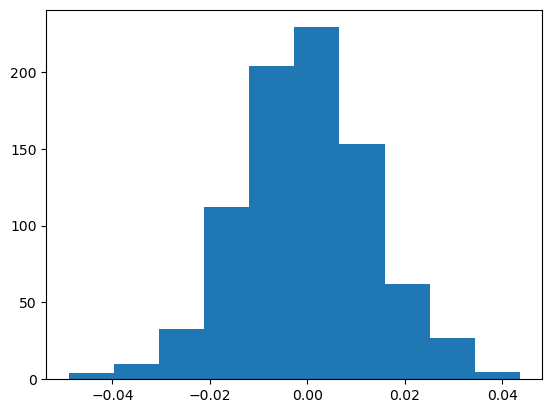

In [105]:
plt.hist(b['A1'])

(array([153.,  20.,  21.,  34.,  15.,  13.,   9.,  11.,   3.,   9.,   4.,
          7.,   7.,   5.,   6.,   6.,   3.,   3.,   8.,   5.,   4.,   4.,
          3.,   4.,   4.,   4.,   5.,   3.,   2.,   3.,   4.,   4.,   2.,
          2.,   6.,   3.,   4.,   3.,   3.,   3.,   3.,   3.,   1.,   3.,
          3.,   4.,   2.,   3.,   3.,   4.,   3.,   2.,   3.,   3.,   2.,
          6.,   2.,   2.,   3.,   1.,   3.,   2.,   3.,   3.,   5.,   3.,
          3.,   5.,   4.,   3.,   2.,   3.,   4.,   5.,   4.,   3.,   6.,
          4.,   4.,   3.,   4.,   5.,   5.,   4.,   7.,   7.,   6.,   5.,
          6.,  12.,   6.,  11.,   3.,  12.,  22.,  13.,  14.,  20.,  22.,
        115.]),
 array([0.0011919 , 0.01117998, 0.02116806, 0.03115614, 0.04114422,
        0.0511323 , 0.06112038, 0.07110846, 0.08109654, 0.09108462,
        0.10107271, 0.11106079, 0.12104887, 0.13103695, 0.14102503,
        0.15101311, 0.16100119, 0.17098927, 0.18097735, 0.19096544,
        0.20095352, 0.2109416 , 0.22092968, 0.

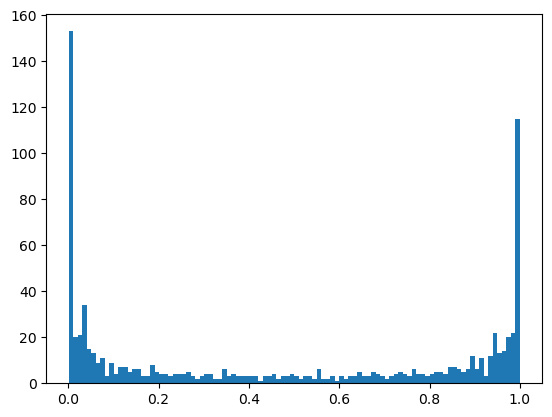

In [103]:
plt.hist(ecdf(b['A1']), bins=100)

In [94]:

a = pd.concat([price_df_coint.A1, price_df_coint.A2], axis=1)

b = (np.log(a) - np.log(a).shift(1)).dropna()
tau = kendalltau(b['A1'], b['A2'])[0]

theta = parameter('gumbel', tau)
lpdf_u = lpdf_copula('gumbel', theta, ecdf(b['A1']), ecdf(b['A2']))
lpdf_v = lpdf_copula('gumbel', theta, ecdf(b['A2']), ecdf(b['A1']))

lpdf_u[0:4], lpdf_v[0:4]



/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_28447/837491513.py:40: RuntimeWarning: divide by zero encountered in power
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_28447/837491513.py:40: RuntimeWarning: invalid value encountered in multiply
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))


(array([5.01973908, 5.01973908, 5.01973908, 4.64318225]),
 array([5.01973908, 5.01973908, 5.01973908, 4.64318225]))

# Dynamic Copula?

In [117]:
'''로그리턴'''
rt_a = (np.log(a) - np.log(a).shift(1)).dropna()

In [121]:
from arch import arch_model

'''GARCH'''
'''r = mu + error / GJR-GARCH(1,1)'''
gjr_am = arch_model(rt_a.iloc[:,0], p=1, o=1, q=1)
res = gjr_am.fit(update_freq=5, disp='off')

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001888. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [160]:
signal = pd.concat([ret_df_coint.A1, ret_df_coint.A2], axis=1)

import statsmodels.api as sm

reg = sm.OLS(signal.A1, np.c_[np.ones(signal.A2.shape), signal.A2.to_numpy()]).fit()
residual = reg.resid

#reg.params[0], reg.params[1]

#plt.plot(signal)

In [147]:
a = pd.concat([ret_df_trade.A1, ret_df_trade.A2], axis=1)

signal = (ret_df_trade.A1 - ret_df_trade.A2).std() * 1.5

a['signal'] = np.where( (a.iloc[:,0] - a.iloc[:,1]) > signal, 1, np.where( (a.iloc[:,0] - a.iloc[:,1]) < -signal, -1, 0))

for idx in range(len(a)):
    '''signal이 없을때'''
    if a.signal.iloc[idx] == 0:
    '''Asset2 팔고, Asset1 사야할 때'''

    if a.signal.iloc[idx] == 1:
    '''Asset1 팔고, Asset2 사야할 때'''
    
    if a.signal.iloc[idx] == -1:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [138]:
signal_tmp.signal.value_counts()

 0    310
-1     26
 1     24
Name: signal, dtype: int64

In [101]:
spread = (ret_df_trade.A1 - ret_df_trade.A2)

In [116]:
import talib as tb

signal = (ret_df_trade.A1 - ret_df_trade.A2).std() * 2

tb_lin_5 = tb.LINEARREG_SLOPE(spread, timeperiod=5) * 1

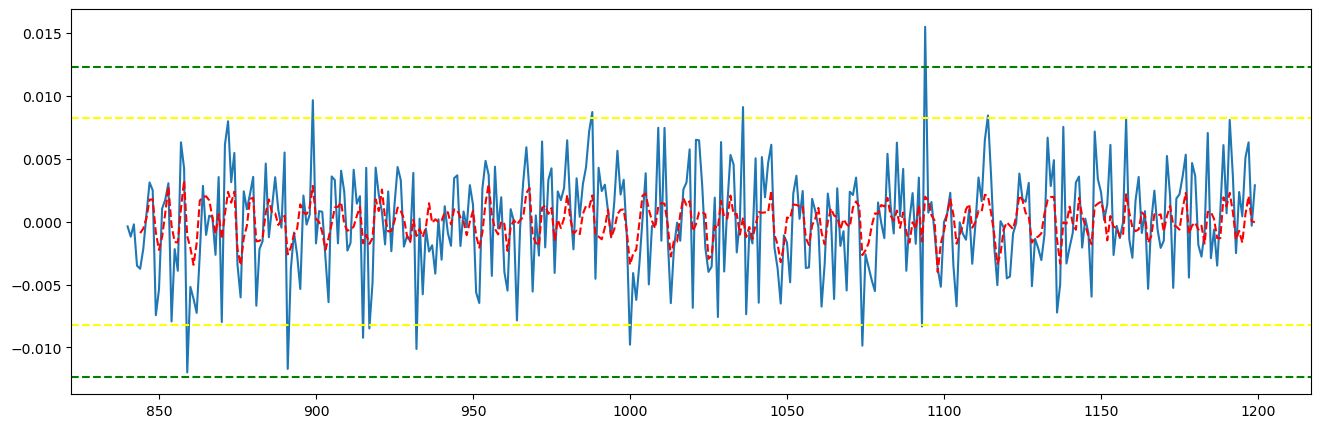

In [117]:
(ret_df_trade.A1 - ret_df_trade.A2).plot(figsize=(16, 5))
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() *  2, linestyle='--', c='yellow')
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() * -2, linestyle='--', c='yellow')
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() *  3, linestyle='--', c='green')
plt.axhline((ret_df_trade.A1 - ret_df_trade.A2).std() * -3, linestyle='--', c='green')
plt.plot(tb_lin_5, linestyle='--', c='red')
plt.show()

In [122]:
tb_ret = (spread - tb_lin_5).dropna().sum()

print(np.round(tb_ret,4))

print()

0.026


In [60]:
(ret_df.A1 - ret_df.A2).std() * 3

0.01250818308351095